# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [25]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [26]:
train[0][0].shape

torch.Size([1, 28, 28])

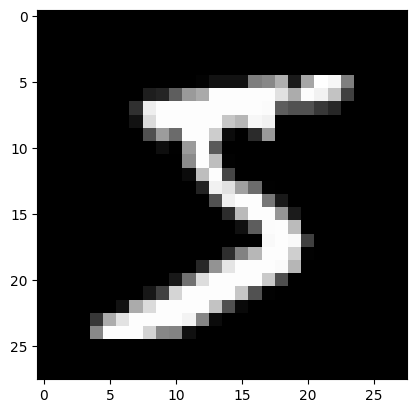

In [27]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

In [28]:
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt


transforms = v2.Compose([
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomApply(transforms=[v2.RandomCrop(size=(28, 28))], p=0.5),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1307], std=[0.3081]),
])




In [29]:
train.data.shape


torch.Size([60000, 28, 28])

In [30]:
# creating augmented traindata



In [31]:
augmented = [
    transforms(img.unsqueeze(0))
    for img in train.data
]

In [32]:
augmented = torch.stack(augmented)

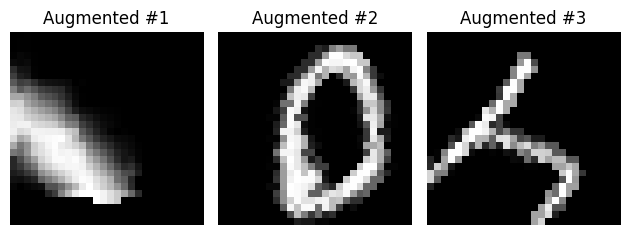

In [33]:
images = augmented[:3]


for i, img in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Augmented #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [34]:
class AE(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["input_shape"], out_features=128)

        self.encoder_output_layer = torch.nn.Linear(
            in_features=128, out_features=128)

        self.decoder_hidden_layer = torch.nn.Linear(
            in_features=128, out_features=128)

        self.decoder_output_layer = torch.nn.Linear(
            in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features):
      activation = self.encoder_hidden_layer(features)
      activation = torch.relu(activation)
      code = self.encoder_output_layer(activation)
      code = torch.relu(code)
      activation = self.decoder_hidden_layer(code)
      activation = torch.relu(activation)
      activation = self.decoder_output_layer(activation)
      reconstructered = torch.relu(activation)
      return reconstructered

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
def train_model(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      X = X.view(X.size(0), -1) # Flatten input

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, X) # Compare with original input

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [37]:
def test_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(X.size(0), -1) # Flatten input
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [38]:
model = AE(input_shape=784)
model.to(device) # transfer model to GPU
model.train()    # set to train mode
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.9)

In [39]:
from torch.utils.data import DataLoader

train_loader = DataLoader(list(zip(augmented, train.targets)), batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, criterion, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 1.159113  [   64/60000]
loss: 1.145973  [ 6464/60000]
loss: 1.103060  [12864/60000]
loss: 1.053033  [19264/60000]
loss: 1.002219  [25664/60000]
loss: 1.062469  [32064/60000]
loss: 1.058739  [38464/60000]
loss: 1.008922  [44864/60000]
loss: 1.032758  [51264/60000]
loss: 0.955966  [57664/60000]
Epoch 2
-------------------------------
loss: 1.093527  [   64/60000]
loss: 1.010153  [ 6464/60000]
loss: 1.065958  [12864/60000]
loss: 1.035580  [19264/60000]
loss: 1.047117  [25664/60000]
loss: 0.963444  [32064/60000]
loss: 1.038752  [38464/60000]
loss: 1.038152  [44864/60000]
loss: 0.997248  [51264/60000]
loss: 0.948776  [57664/60000]
Epoch 3
-------------------------------
loss: 1.018703  [   64/60000]
loss: 0.988986  [ 6464/60000]
loss: 1.012368  [12864/60000]
loss: 1.002386  [19264/60000]
loss: 0.953709  [25664/60000]
loss: 0.901235  [32064/60000]
loss: 0.945480  [38464/60000]
loss: 0.877007  [44864/60000]
loss: 0.905660  [51264/60000]
loss: 0.83

## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [40]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [41]:
noise = AddGaussianNoise(mean=0., std=0.1)

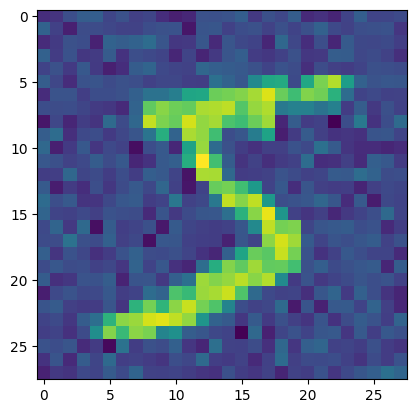

In [42]:
plt.imshow(noise(train.data[0].float() / 255.0))

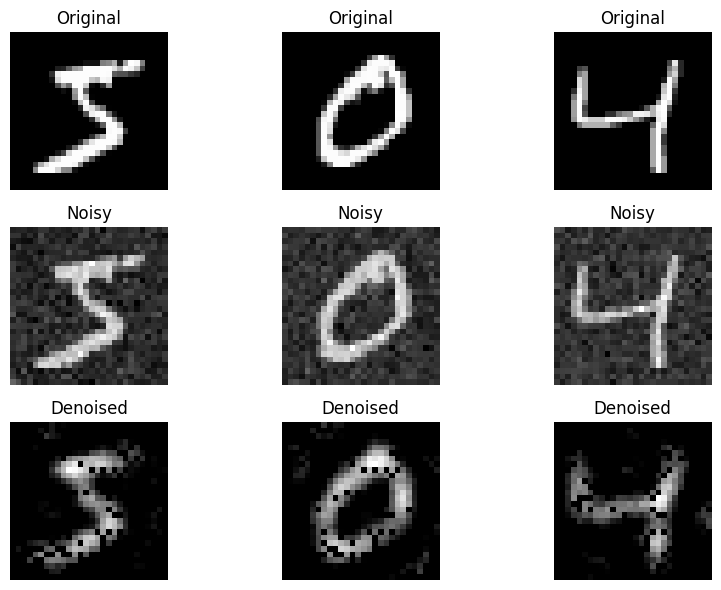

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(9, 6))
for i in range(3):
    clean = train.data[i].float() / 255.0
    noisy = noise(clean)
    inp = noisy.unsqueeze(0).to(device).view(1, -1)
    out = model(inp).view(28, 28).cpu().detach()

    axs[0, i].imshow(clean, cmap="gray")
    axs[0, i].set_title("Original")
    axs[1, i].imshow(noisy, cmap="gray")
    axs[1, i].set_title("Noisy")
    axs[2, i].imshow(out, cmap="gray")
    axs[2, i].set_title("Denoised")

    for j in range(3):
        axs[j, i].axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

In [44]:
model.eval()

# Alle Trainingsbilder vorbereiten
all_imgs = train.data.float() / 255.0      # [60000, 28, 28]
all_imgs = all_imgs.view(len(all_imgs), -1).to(device)  # [60000, 784]




In [45]:
with torch.no_grad():
    x = all_imgs.to(device)              # [60000, 784]
    x = model.encoder_hidden_layer(x)
    x = torch.relu(x)
    latent = model.encoder_output_layer(x)
    latent = torch.relu(latent)          # [60000, 128]


In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(latent.cpu().numpy())


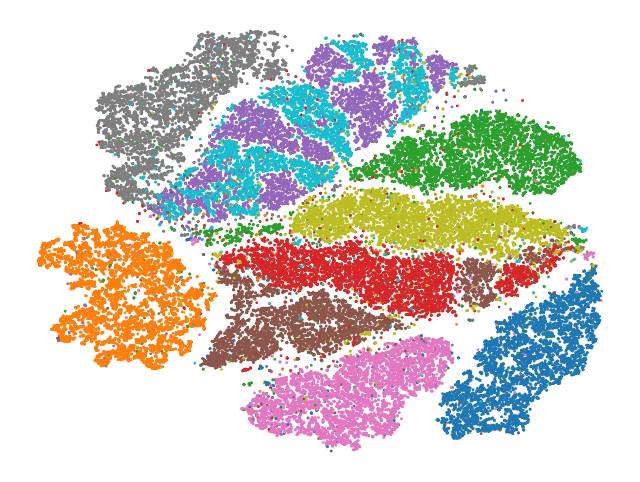

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=train.targets, cmap='tab10', s=1)
plt.axis('off')
plt.show()
